In [1]:
include("cosmology_vars.jl")
include("nu_osc_params.jl")

using DelimitedFiles
using Plots
using Interpolations
using LaTeXStrings
using QuadGK
using SpecialFunctions;

In [2]:
function F0_tint_func(F0vec::Vector{Float64})
    es = range(0, 100, 2000)
    F0int_ne = Interpolations.interpolate((vec(es),), F0vec, Gridded(Linear()))
    return extrapolate(F0int_ne, 0.0)
end

F0s_vec = readdlm("F0s_vec.txt", comments=true)

F0_νe_270sm, F0_νebar_270sm, F0_νx_270sm = F0_tint_func(vec(F0s_vec[:, 1])), F0_tint_func(vec(F0s_vec[:, 2])), F0_tint_func(vec(F0s_vec[:, 3]))
F0_νe_112sm, F0_νebar_112sm, F0_νx_112sm = F0_tint_func(vec(F0s_vec[:, 4])), F0_tint_func(vec(F0s_vec[:, 5])), F0_tint_func(vec(F0s_vec[:, 6]))
F0_νe_bh, F0_νebar_bh, F0_νx_bh = F0_tint_func(vec(F0s_vec[:, 7])), F0_tint_func(vec(F0s_vec[:, 8])), F0_tint_func(vec(F0s_vec[:, 9]))

function F0(E, β, sm)
    if β == "e" && sm == "small"
        return F0_νe_112sm(E)
    elseif β == "e" && sm == "large"
        return F0_νe_270sm(E)
    elseif β == "e" && sm == "bh"
        return F0_νe_bh(E)
    elseif β == "ebar" && sm == "small"
        return F0_νebar_112sm(E)
    elseif β == "ebar" && sm == "large"
        return F0_νebar_270sm(E)
    elseif β == "ebar" && sm == "bh"
        return F0_νebar_bh(E)   
    elseif β == "x" && sm == "small"
        return F0_νx_112sm(E)
    elseif β == "x" && sm == "large"
        return F0_νx_270sm(E)
    elseif β == "x" && sm == "bh"
        return F0_νx_bh(E)
    else
        return 0
    end
end

# Oscillations thru the SN medium
# Accounting for oscillations thru the SN medium

s12 = 0.297
c12 = 1 - s12
PH = 0

# ordering = "NO" (normal ordering) or "IO" (inverted ordering)
function F(E, β, sm, ordering)
    if ordering == "NO"
        if β == "e"
            return F0(E, "x", sm)
        elseif β == "ebar"
            return c12*F0(E, "ebar", sm) + s12*F0(E, "x", sm)
        elseif β == "x"
            return 0.5*(F0(E, "e", sm) + F0(E, "x", sm))
        elseif β == "xbar"
            return 0.5*(s12*F0(E, "ebar", sm) + (1 + c12)*F0(E, "x", sm))
        else
            return 0
        end
    elseif ordering == "IO"
        if β == "e"
            return s12*F0(E, "e", sm) + c12*F0(E, "x", sm)
        elseif β == "ebar"
            return F0(E, "x", sm)
        elseif β == "x"
            return 0.5*(c12*F0(E, "e", sm) + (1 + s12)*F0(E, "x", sm))
        elseif β == "xbar"
            return 0.5*(F0(E, "ebar", sm) + F0(E, "x", sm))
        else
            return 0
        end
    else
        return 0
    end
end

# In the mass basis now: i = 1, 2, 3, nubar = true or false
function Fmass(E, i, sm, ordering, nubar)
    if nubar==false
        return Usqred(ordering)[1, i]*F(E, "e", sm, ordering) + (1 - Usqred(ordering)[1, i])*F(E, "x", sm, ordering)
    elseif nubar==true
        return Usqred(ordering)[1, i]*F(E, "ebar", sm, ordering) + (1 - Usqred(ordering)[1, i])*F(E, "xbar", sm, ordering)
    else
        return 0
    end
end;

In [3]:
# We can take normchoice to be SNRnorm, SNRnorm_low, or SNRnorm_high
function DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice)
    c0 = 3e8 # m s^(-1)
    if bh_frac == "21"
        return 0.00208 * (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar) 
        + (ηAD(22, 15)+ηAD(27, 25))*Fmass(E*(1+z)/(1+z0), i, "large", ordering, nubar) + (ηAD(25, 22)+ηAD(125, 27))*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))
    elseif bh_frac == "41"
        return 0.00208 * (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar) 
        + ηAD(125, 15)*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))
    elseif bh_frac == "09"
        return 0.00208 * (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar)
        + ηAD(40, 15)*Fmass(E*(1+z)/(1+z0), i, "large", ordering, nubar) + ηAD(125, 40)*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))
    else
        return 0
    end
end

DSNB(E, z0, i, nubar, ordering, bh_frac, normchoice) = 1/(1+z0) * quadgk(z -> DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice), z0, 5, rtol=1e-2)[1];

In [ ]:
@btime DSNB_integrand(1, 0, 0.1, 1, true, "IO", "21", SNRnorm)

In [268]:
DSNB.(es_dsnb_test, 0, 1, true, "NO", "21", SNRnorm)

100-element Vector{Float64}:
 0.21349522670965054
 0.5790555930000054
 0.9613259942603185
 1.2856978072217493
 1.5264615162283364
 1.6840404108427471
 1.7701058612702827
 1.7994282426473984
 1.7860661965876232
 1.7419535488241578
 1.6766249749059634
 1.5974393387763257
 1.5099450713464404
 ⋮
 0.002801011336747888
 0.0026029325395147823
 0.002419606017183155
 0.0022498709919791817
 0.0020926709891078855
 0.001947045307302159
 0.0018120942420867224
 0.0016869989072918583
 0.0015710109661122582
 0.0014634293789370142
 0.001363614995031456
 0.0012709838571883143

In [4]:
# Define this effective length function
LeffIntegrand(z) = (H0*sqrt(energy_matter*(1+z)^3 + energy_dark))^(-1)*(1+z)^(-2)

leff_quadint(z0) = quadgk(z -> LeffIntegrand(z), 0, z0)[1]

zs_leff = range(0, 5, 1000)
leff_ne = Interpolations.interpolate((vec(zs_leff),), leff_quadint.(zs_leff), Gridded(Linear()))
leff = extrapolate(leff_ne, 0.0)

function decay(E, α, z0, z)
    scalefactor = 4.68e28
    return exp(-scalefactor*α*(leff(z) - leff(z0))*(1+z0)/E)
end;

In [197]:
function ψSH(Eh, El, hc)
    if hc
        return 2*El/Eh^2
    else
        return (2/Eh)*(1-(El/Eh))
    end
end

function branch_3ν(j, i, ordering)
    if ordering == "NO"
        if j == 3
            return 0.25
        elseif j == 2
            return 0.5
        else
            return println("error: j is not a valid index")
        end
    elseif ordering == "IO"
        if j == 2
            return 0.25
        elseif j == 1
            return 0.5
        else
            return println("error: j is not a valid index")
        end
    else
        return println("error: ordering must be either 'NO' or 'IO'")
    end
end;

In [327]:
# Invisible decay

function DSNB_idecay(E, z0, α, i, nubar, ordering, bh_frac, normchoice)
    return quadgk(z -> 1/(1+z0) * DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice)*decay(E, α, z0, z), z0, 5, rtol=1e-2)[1]
end

function DSNB_idecay_νe(E, z0, α1, α2, α3, nubar, ordering, bh_frac, normchoice)
    ν1 = DSNB_idecay(E, z0, α1, 1, nubar, ordering, bh_frac, normchoice)
    ν2 = DSNB_idecay(E, z0, α2, 2, nubar, ordering, bh_frac, normchoice)
    ν3 = DSNB_idecay(E, z0, α3, 3, nubar, ordering, bh_frac, normchoice)
    return Usqred(ordering)[1, 1]*ν1 + Usqred(ordering)[1, 2]*ν2 + Usqred(ordering)[1, 3]*ν3
end;

In [ ]:
# 2ν SH treatment (but QD for IO 2 → 1)

# Here we take m_j > m_i
function qcontrib_2ν(E, z0, z, j, jbar, i, ibar, αj, ordering, bh_frac, normchoice)

    if ordering == "NO" && j <= i
        return println("error: not kinematically allowed")
    elseif ordering == "IO" && j == 1 && i == 2
        return println("error: not kinematically allowed")
    elseif ordering == "IO" && j == 3 && i == 1
        return println("error: not kinematically allowed")
    elseif ordering == "IO" && j == 3 && i == 2
        return println("error: not kinematically allowed")
    elseif ordering == "IO" && j == 2 && i == 1
        if jbar != ibar
            return 0.0
        else
            Ers = E*(1+z)/(1+z0)
            qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
            return qnorm * (c0/Hubble(z))*DSNB_idecay(Ers, z, αj, j, jbar, ordering, bh_frac, normchoice) * (αj/Ers)
        end
    else
        if jbar == ibar
            hc = true
        else
            hc = false
        end

        Ers = E*(1+z)/(1+z0)

        qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
        integrand(Eprime) = qnorm * (c0/Hubble(z))*DSNB_idecay(Eprime, z, αj, j, jbar, ordering, bh_frac, normchoice) * (αj * 0.5/Eprime) * ψSH(Eprime, Ers, hc)
        Emax = Ers + 50

        return quadgk(Eprime -> integrand(Eprime), Ers, Emax, rtol=1e-2)[1]
    end
end

function DSNB_vdecay_2ν(E, αj, i, ibar, ordering, bh_frac, normchoice)
    if αj == 0
        return DSNB_idecay(E, 0, 0, i, ibar, ordering, bh_frac, normchoice)
    elseif ordering == "NO" && i == 3
        return DSNB_idecay(E, 0, αj, i, ibar, "NO", bh_frac, normchoice)
    elseif ordering == "IO" && i == 2
        return DSNB_idecay(E, 0, αj, i, ibar, "IO", bh_frac, normchoice)
    else
        # Here, for NO we take ν2 to be stable and for IO we take ν1 to be stable, and we take the lightest mass states to be stable as well
        if ordering == "NO"
            qint = quadgk(z -> (qcontrib_2ν(E, 0, z, 3, false, i, ibar, αj, "NO", bh_frac, normchoice)+qcontrib_2ν(E, 0, z, 3, true, i, ibar, αj, "NO", bh_frac, normchoice)), 0, 5, rtol=1e-2)[1]
        elseif ordering == "IO"
            qint = quadgk(z -> (qcontrib_2ν(E, 0, z, 2, false, i, ibar, αj, "IO", bh_frac, normchoice)+qcontrib_2ν(E, 0, z, 2, true, i, ibar, αj, "IO", bh_frac, normchoice)), 0, 5, rtol=1e-2)[1]
        else
            return println("error: ordering takes either 'NO' or 'IO'")
        end
        return DSNB_idecay(E, 0, 0, i, ibar, ordering, bh_frac, normchoice) + qint
    end
end;

# Other few cases where the heaviest mass state and lightest mass state are stable, and the middle mass state decays into the lightest mass state
function DSNB_vdecay_2ν_alt(E, αj, i, ibar, ordering, bh_frac, normchoice)
    if αj == 0
        return DSNB_idecay(E, 0, 0, i, ibar, ordering, bh_frac, normchoice)
    elseif ordering == "NO" && i == 2
        return DSNB_idecay(E, 0, αj, i, ibar, "NO", bh_frac, normchoice)
    elseif ordering == "IO" && i == 1
        return DSNB_idecay(E, 0, αj, i, ibar, "IO", bh_frac, normchoice)
    elseif ordering == "NO" && i == 3
        return DSNB_idecay(E, 0, 0, i, ibar, "NO", bh_frac, normchoice)
    elseif ordering == "IO" && i == 2
        return DSNB_idecay(E, 0, 0, i, ibar, "IO", bh_frac, normchoice)
    else
        # Here, for NO we take ν1 to be stable and for IO we take ν2 to be stable, and we take the lightest mass states to be stable as well
        if ordering == "NO"
            qint = quadgk(z -> (qcontrib_2ν(E, 0, z, 2, false, i, ibar, αj, "NO", bh_frac, normchoice)+qcontrib_2ν(E, 0, z, 2, true, i, ibar, αj, "NO", bh_frac, normchoice)), 0, 5, rtol=1e-2)[1]
        elseif ordering == "IO"
            qint = quadgk(z -> (qcontrib_2ν(E, 0, z, 1, false, i, ibar, αj, "IO", bh_frac, normchoice)+qcontrib_2ν(E, 0, z, 1, true, i, ibar, αj, "IO", bh_frac, normchoice)), 0, 5, rtol=1e-2)[1]
        else
            return println("error: ordering takes either 'NO' or 'IO'")
        end
        return DSNB_idecay(E, 0, 0, i, ibar, ordering, bh_frac, normchoice) + qint
    end
end

# daughter specifies the state the heaviest mass state decays into in our 2ν framework

function DSNB_vdecay_2ν_νe(E, α, daughter, ebar, ordering, bh_frac, normchoice)
    if ordering == "NO"
        if daughter == 1
            α1, α2, α3 = α, 0.0, α
        elseif daughter == 2
            α1, α2, α3 = 0.0, α, α
        else
            return println("error: for NO, 'daughter' must be either ν1 or ν2")
        end
    elseif ordering == "IO"
        if daughter == 3
            α3, α1, α2 = α, 0.0, α
        elseif daughter == 1
            α3, α1, α2 = 0.0, α, α
        else
            return println("error: for IO, 'daughter' must be either ν1 or ν3")
        end
    else
        return println("error: ordering must take either 'NO' or 'IO'")
    end
    ν3 = DSNB_vdecay_2ν(E, α3, 3, ebar, ordering, bh_frac, normchoice)
    ν2 = DSNB_vdecay_2ν(E, α2, 2, ebar, ordering, bh_frac, normchoice)
    ν1 = DSNB_vdecay_2ν(E, α1, 1, ebar, ordering, bh_frac, normchoice)
    return Usqred("NO")[1, 1]*ν1 + Usqred("NO")[1, 2]*ν2 + Usqred("NO")[1, 3]*ν3
end

function DSNB_vdecay_2ν_νe_alt(E, α, ebar, ordering, bh_frac, normchoice)
    if ordering == "NO"
        α1, α2, α3 = α, α, 0.0
    elseif ordering == "IO"
        α1, α2, α3 = α, 0.0, α
    else
        return println("error: ordering must take either 'NO' or 'IO'")
    end
    ν3 = DSNB_vdecay_2ν_alt(E, α3, 3, ebar, ordering, bh_frac, normchoice)
    ν2 = DSNB_vdecay_2ν_alt(E, α2, 2, ebar, ordering, bh_frac, normchoice)
    ν1 = DSNB_vdecay_2ν_alt(E, α1, 1, ebar, ordering, bh_frac, normchoice)
    return Usqred("NO")[1, 1]*ν1 + Usqred("NO")[1, 2]*ν2 + Usqred("NO")[1, 3]*ν3
end;

In [198]:
# 3ν NO SH treatment

function DSNB_vdecay_3_NO(E, z0, α3, threebar, bh_frac, normchoice)
    function decay_integrand(E, z0, z, α3, threebar, bh_frac, normchoice)
        if α3 == 0
            return DSNB_integrand(E, z0, z, 3, threebar, "NO", bh_frac, normchoice)
        else
            int = DSNB_integrand(E, z0, z, 3, threebar, "NO", bh_frac, normchoice)*decay(E, α3, z0, z) 
            if isnan(int) || isinf(int)
                return 0.0
            else
                return int
            end
        end
    end
    return 1/(1+z0) * quadgk(z -> decay_integrand(E, z0, z, α3, threebar, bh_frac, normchoice), z0, 5, rtol=1e-2)[1]
end

function q3icontrib_NO(E, z0, z, α3, threebar, i, ibar, bh_frac, normchoice)
    if threebar == ibar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime, z) = qnorm * (c0/Hubble(z))*DSNB_vdecay_3_NO(Eprime, z, α3, threebar, bh_frac, normchoice) * (α3 * branch_3ν(3, i, "NO")/Eprime) * ψSH(Eprime, Ers, hc)
    
    Emax = Ers + 50

    return quadgk(Eprime -> integrand(Eprime, z), Ers, Emax, rtol=1e-2)[1]

end

function DSNB_vdecay_2_NO(E, z0, α3, α2, twobar, bh_frac, normchoice)
    integrand(z) = (DSNB_integrand(E, z0, z, 2, twobar, "NO", bh_frac, normchoice) +
                          q3icontrib_NO(E, z0, z, α3, true, 2, twobar, bh_frac, normchoice) + q3icontrib_NO(E, z0, z, α3, false, 2, twobar, bh_frac, normchoice))*decay(E, α2, z0, z)
    return (1/(1+z0)) * quadgk(z -> integrand(z), z0, 5, rtol=1e-2)[1]
end

function q21contrib_NO(E, z0, z, α3, α2, twobar, onebar, bh_frac, normchoice)
    if twobar == onebar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime, z) = qnorm * (c0/Hubble(z))*DSNB_vdecay_2_NO(Eprime, z, α3, α2, twobar, bh_frac, normchoice) * (α2 * branch_3ν(2, 1, "NO")/Eprime) * ψSH(Eprime, Ers, hc)
    
    Emax = Ers + 50

    return quadgk(Eprime -> integrand(Eprime, z), Ers, Emax, rtol=1e-2)[1]

end

# z0 is always 0 here because we're only concerned with the flux at Earth
function DSNB_vdecay_1_NO(E, α3, α2, onebar, bh_frac, normchoice)
    integrand(z) = (DSNB_integrand(E, 0, z, 1, onebar, "NO", bh_frac, normchoice)
                    + q21contrib_NO(E, 0, z, α3, α2, true, onebar, bh_frac, normchoice)
                    + q21contrib_NO(E, 0, z, α3, α2, false, onebar, bh_frac, normchoice)
                    + q3icontrib_NO(E, 0, z, α3, true, 1, onebar, bh_frac, normchoice)
                    + q3icontrib_NO(E, 0, z, α3, false, 1, onebar, bh_frac, normchoice))
    return quadgk(z -> integrand(z), 0, 5, rtol=1e-2)[1]
end;

In [459]:
# Case A
# ν2 → ν1, ν2 → ν3, no ν1 → ν3:
# B_21 = 0.5 (no hf), B_23 = 0.25, B_13 = 0
# NB: here if we want to only consider visible decays, we should set α1 to 0 always

# Case B
# ν2 → ν1, ν1 → ν3, no ν2 → ν3:
# B_21 = 1 (no hf), B_13 = 0.5, B_23 = 0

# Case C
# ν2 → ν3, ν1 → ν3, no ν2 → ν1
# B_23 = 0.5, B_13 = 0.5, B_21 = 0

# Democratic
# ν2 → ν3, ν1 → ν3, ν2 → ν1
# B_21 = B_23 = 1/3, B_13 = 0.5

# Note: supposing validity of SH and QD approximations, branching ratios are set in B and C

function branching_3ν(casechoice, j, jbar, i, ibar)
    if casechoice == "A"
        if j == 2 && i == 1 && jbar == ibar
            return 0.5
        elseif j == 2 && i == 3
            return 0.25
        else
            return 0.0
        end
    elseif casechoice == "B"
        if j == 2 && i == 1 && jbar == ibar
            return 1.0
        elseif j == 1 && i == 3
            return 0.5
        else 
            return 0.0
        end
    elseif casechoice == "C"
        if j == 2 && i == 3
            return 0.5
        elseif j == 1 && i == 3
            return 0.5
        else
            return 0.0
        end
    elseif casechoice == "democratic"
        if (j == 2 && i == 1 && jbar == ibar) || (j == 2 && i == 3)
            return 1/3
        elseif j == 1 && i == 3
            return 0.5
        else
            return 0.0
        end
    else
        return 0.0
    end
end;

In [478]:
# 3ν IO treatment (2 → 1 QD, 2/1 → 3 SH)

function DSNB_vdecay_2_IO(E, z0, α2, twobar, bh_frac, normchoice)
    function decay_integrand(E, z0, z, α2, twobar, bh_frac, normchoice)
        if α2 == 0
            return DSNB_integrand(E, z0, z, 2, twobar, "IO", bh_frac, normchoice)
        else
            int = DSNB_integrand(E, z0, z, 2, twobar, "IO", bh_frac, normchoice)*decay(E, α2, z0, z) 
            if isnan(int) || isinf(int)
                return 0.0
            else
                return int
            end
        end
    end
    return 1/(1+z0) * quadgk(z -> decay_integrand(E, z0, z, α2, twobar, bh_frac, normchoice), z0, 5, rtol=1e-2)[1]
end

function q21contrib_IO(E, z0, z, α2, nubar, casechoice, bh_frac, normchoice)

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    return qnorm * (c0/Hubble(z)) * DSNB_vdecay_2_IO(Ers, z, α2, nubar, bh_frac, normchoice) * (α2 * branching_3ν(casechoice, 2, nubar, 1, nubar)/Ers)
end

function DSNB_vdecay_1_IO(E, z0, α2, α1, nubar, casechoice, bh_frac, normchoice)
    if casechoice == "A"
        α1 = 0
    end
    integrand(z) = (DSNB_integrand(E, z0, z, 1, nubar, "IO", bh_frac, normchoice) +
                        q21contrib_IO(E, z0, z, α2, nubar, casechoice, bh_frac, normchoice))*decay(E, α1, z0, z)
    return (1/(1+z0)) * quadgk(z -> integrand(z), z0, 5, rtol=1e-2)[1]
end

function q23contrib_IO(E, z0, z, α2, twobar, threebar, casechoice, bh_frac, normchoice)

    if twobar == threebar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime, z) = qnorm * (c0/Hubble(z))*DSNB_vdecay_2_IO(Eprime, z, α2, twobar, bh_frac, normchoice) * (α2 * branching_3ν(casechoice, 2, twobar, 3, threebar)/Eprime) * ψSH(Eprime, Ers, hc)

    Emax = Ers + 50
    return quadgk(Eprime -> integrand(Eprime, z), Ers, Emax, rtol=1e-2)[1]
end

function q13contrib_IO(E, z0, z, α2, α1, onebar, threebar, casechoice, bh_frac, normchoice)

    if onebar == threebar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime) = qnorm * (c0/Hubble(z))*DSNB_vdecay_1_IO(Eprime, z, α2, α1, onebar, casechoice, bh_frac, normchoice) * (α1 * branching_3ν(casechoice, 1, onebar, 3, threebar)/Eprime) * ψSH(Eprime, Ers, hc)

    Emax = Ers + 50
    return quadgk(Eprime -> integrand(Eprime), Ers, Emax, rtol=1e-2)[1]
end

function DSNB_vdecay_3_IO(E, α2, α1, threebar, casechoice, bh_frac, normchoice)
    integrand(z) = (DSNB_integrand(E, 0, z, 3, threebar, "IO", bh_frac, normchoice)
                    + q23contrib_IO(E, 0, z, α2, true, threebar, casechoice, bh_frac, normchoice)
                    + q23contrib_IO(E, 0, z, α2, false, threebar, casechoice, bh_frac, normchoice)
                    + q13contrib_IO(E, 0, z, α2, α1, true, threebar, casechoice, bh_frac, normchoice)
                    + q13contrib_IO(E, 0, z, α2, α1, false, threebar, casechoice, bh_frac, normchoice))
    return quadgk(z -> integrand(z), 0, 5, rtol=1e-2)[1]
end

function DSNB_vdecay_3ν_νe_IO(E, α2, α1, nubar, casechoice, bh_frac, normchoice)

    ν3 = DSNB_vdecay_3_IO(E, α2, α1, nubar, casechoice, bh_frac, normchoice)
    ν2 = DSNB_vdecay_2_IO(E, 0, α2, nubar, bh_frac, normchoice)
    ν1 = DSNB_vdecay_1_IO(E, 0, α2, α1, nubar, casechoice, bh_frac, normchoice)
    
    Usqred("NO")[1, 1]*ν1 + Usqred("NO")[1, 2]*ν2 + Usqred("NO")[1, 3]*ν3
end;

In [552]:
function total_nus_3ν_IO(α2, α1, casechoice, bh_frac, normchoice)
    total_nu_spectrum(E) = (DSNB_vdecay_2_IO(E, 0, α2, true, bh_frac, normchoice) +
                            DSNB_vdecay_2_IO(E, 0, α2, false, bh_frac, normchoice) +
                            DSNB_vdecay_1_IO(E, 0, α2, α1, true, casechoice, bh_frac, normchoice) +
                            DSNB_vdecay_1_IO(E, 0, α2, α1, false, casechoice, bh_frac, normchoice) +
                            DSNB_vdecay_3_IO(E, α2, α1, true, casechoice, bh_frac, normchoice) +
                            DSNB_vdecay_3_IO(E, α2, α1, false, casechoice, bh_frac, normchoice))
    return quadgk(E -> total_nu_spectrum(E), 0, 100, rtol=1e-2)[1]
end;

In [553]:
totν_null = total_nus_3ν_IO(0, 0, "A", "21", SNRnorm)

90.48731018862716

In [554]:
totν_A = total_nus_3ν_IO(10^(-24), 10^(-24), "A", "21", SNRnorm)
totν_B = total_nus_3ν_IO(10^(-24), 10^(-24), "B", "21", SNRnorm)

LoadError: InterruptException:

In [558]:
println("null case: $totν_null, A case: $totν_A, B case: $totν_B")

null case: 90.48731018862716, A case: 90.48742688893905, B case: 90.44788073593429


In [ ]:
totν_C = total_nus_3ν_IO(10^(-24), 10^(-24), "C", "21", SNRnorm)
totν_D = total_nus_3ν_IO(10^(-24), 10^(-24), "democratic", "21", SNRnorm);

In [476]:
DSNB_vdecay_3ν_νe_IO(1, 10^(-25), 10^(-25), true, "democratic", "21", SNRnorm)

0.16801048649897782

In [211]:
@time DSNB_vdecay_3ν_νe_IO(1, 10^(-25), 10^(-25), true, "21", SNRnorm)

  2.426825 seconds (38.27 M allocations: 595.838 MiB, 9.13% gc time)


0.16801048649897782

In [154]:
es_dsnb_test = range(0.5, 40, 100)

dsnb_vdecay_νe_3ν_25 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-25), 10^(-25), true, "21", SNRnorm);

In [169]:
dsnb_vdecay_νe_3ν_24 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-24), 10^(-24), true, "21", SNRnorm)
dsnb_vdecay_νe_3ν_26 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-26), 10^(-26), true, "21", SNRnorm)
dsnb_vdecay_νe_3ν_26_25 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-26), 10^(-25), true, "21", SNRnorm)
dsnb_vdecay_νe_3ν_25_26 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-25), 10^(-26), true, "21", SNRnorm)
dsnb_vdecay_νe_3ν_26_24 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-26), 10^(-24), true, "21", SNRnorm)
dsnb_vdecay_νe_3ν_24_26 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-24), 10^(-26), true, "21", SNRnorm)
dsnb_vdecay_νe_3ν_25_24 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-25), 10^(-24), true, "21", SNRnorm)
dsnb_vdecay_νe_3ν_24_25 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-24), 10^(-25), true, "21", SNRnorm);

In [479]:
DSNB_vdecay_νe_3ν_A_24 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-24), 10^(-24), true, "A", "21", SNRnorm)
DSNB_vdecay_νe_3ν_A_25 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-25), 10^(-25), true, "A", "21", SNRnorm)
DSNB_vdecay_νe_3ν_A_26 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-26), 10^(-26), true, "A", "21", SNRnorm);

In [480]:
DSNB_vdecay_νe_3ν_B_24 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-24), 10^(-24), true, "B", "21", SNRnorm)
DSNB_vdecay_νe_3ν_B_25 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-25), 10^(-25), true, "B", "21", SNRnorm)
DSNB_vdecay_νe_3ν_B_26 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-26), 10^(-26), true, "B", "21", SNRnorm)
DSNB_vdecay_νe_3ν_B_24_25 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-24), 10^(-25), true, "B", "21", SNRnorm)
DSNB_vdecay_νe_3ν_B_25_24 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-25), 10^(-24), true, "B", "21", SNRnorm)
DSNB_vdecay_νe_3ν_B_24_26 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-24), 10^(-26), true, "B", "21", SNRnorm)
DSNB_vdecay_νe_3ν_B_26_24 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-26), 10^(-24), true, "B", "21", SNRnorm)
DSNB_vdecay_νe_3ν_B_25_26 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-25), 10^(-26), true, "B", "21", SNRnorm)
DSNB_vdecay_νe_3ν_B_26_25 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-26), 10^(-25), true, "B", "21", SNRnorm);

In [481]:
DSNB_vdecay_νe_3ν_C_24 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-24), 10^(-24), true, "C", "21", SNRnorm)
DSNB_vdecay_νe_3ν_C_25 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-25), 10^(-25), true, "C", "21", SNRnorm)
DSNB_vdecay_νe_3ν_C_26 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-26), 10^(-26), true, "C", "21", SNRnorm)
DSNB_vdecay_νe_3ν_C_24_25 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-24), 10^(-25), true, "C", "21", SNRnorm)
DSNB_vdecay_νe_3ν_C_25_24 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-25), 10^(-24), true, "C", "21", SNRnorm)
DSNB_vdecay_νe_3ν_C_24_26 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-24), 10^(-26), true, "C", "21", SNRnorm)
DSNB_vdecay_νe_3ν_C_26_24 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-26), 10^(-24), true, "C", "21", SNRnorm)
DSNB_vdecay_νe_3ν_C_25_26 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-25), 10^(-26), true, "C", "21", SNRnorm)
DSNB_vdecay_νe_3ν_C_26_25 = DSNB_vdecay_3ν_νe_IO.(es_dsnb_test, 10^(-26), 10^(-25), true, "C", "21", SNRnorm);

In [482]:
dsnb_3nu_decays_plus = hcat(
    DSNB_vdecay_νe_3ν_A_24,
    DSNB_vdecay_νe_3ν_A_25,
    DSNB_vdecay_νe_3ν_A_26,
    DSNB_vdecay_νe_3ν_B_24,
    DSNB_vdecay_νe_3ν_B_25,
    DSNB_vdecay_νe_3ν_B_26,
    DSNB_vdecay_νe_3ν_B_24_25,
    DSNB_vdecay_νe_3ν_B_25_24,
    DSNB_vdecay_νe_3ν_B_24_26,
    DSNB_vdecay_νe_3ν_B_26_24,
    DSNB_vdecay_νe_3ν_B_25_26,
    DSNB_vdecay_νe_3ν_B_26_25,
    DSNB_vdecay_νe_3ν_C_24,
    DSNB_vdecay_νe_3ν_C_25,
    DSNB_vdecay_νe_3ν_C_26,
    DSNB_vdecay_νe_3ν_C_24_25,
    DSNB_vdecay_νe_3ν_C_25_24,
    DSNB_vdecay_νe_3ν_C_24_26,
    DSNB_vdecay_νe_3ν_C_26_24,
    DSNB_vdecay_νe_3ν_C_25_26,
    DSNB_vdecay_νe_3ν_C_26_25
)
writedlm("dsnb_3nu_decays_plus.txt", dsnb_3nu_decays_plus)

In [170]:
dsnb_3nu_decays = hcat(
    dsnb_vdecay_νe_3ν_24,
    dsnb_vdecay_νe_3ν_25,
    dsnb_vdecay_νe_3ν_26,
    dsnb_vdecay_νe_3ν_26_25,
    dsnb_vdecay_νe_3ν_25_26,
    dsnb_vdecay_νe_3ν_26_24,
    dsnb_vdecay_νe_3ν_24_26,
    dsnb_vdecay_νe_3ν_25_24,
    dsnb_vdecay_νe_3ν_24_25
)

writedlm("dsnb_3nu_decays.txt", dsnb_3nu_decays)

In [283]:
dsnb_2ν_decays = readdlm("vdecay_data.txt", comments=true)

dsnb_nodecay_IO = dsnb_2ν_decays[:, 5]
dsnb_vdecay_νe_2ν_25_IO_daughter3 = dsnb_2ν_decays[:, 36]
dsnb_vdecay_νe_2ν_25_IO_alt = dsnb_2ν_decays[:, 37];

In [354]:
dsnb_idecay_25_0_0 = DSNB_idecay_νe.(es_dsnb_test, 0, 10^(-25), 0, 0, true, "IO", "21", SNRnorm)
dsnb_idecay_0_25_0 = DSNB_idecay_νe.(es_dsnb_test, 0, 0, 10^(-25), 0, true, "IO", "21", SNRnorm)
dsnb_idecay_0_0_25 = DSNB_idecay_νe.(es_dsnb_test, 0, 0, 0, 10^(-25), true, "IO", "21", SNRnorm)
dsnb_idecay_25_25_0 = DSNB_idecay_νe.(es_dsnb_test, 0, 10^(-25), 10^(-25), 0, true, "IO", "21", SNRnorm)
dsnb_vdecay_2ν_2to3_25 = DSNB_vdecay_2ν_νe.(es_dsnb_test, 10^(-25), 3, true, "IO", "21", SNRnorm)
dsnb_vdecay_2ν_1to3_25 = DSNB_vdecay_2ν_νe_alt.(es_dsnb_test, 10^(-25), true, "IO", "21", SNRnorm);

In [360]:
dsnb_idecay_26_0_0 = DSNB_idecay_νe.(es_dsnb_test, 0, 10^(-26), 0, 0, true, "IO", "21", SNRnorm)
dsnb_idecay_0_26_0 = DSNB_idecay_νe.(es_dsnb_test, 0, 0, 10^(-26), 0, true, "IO", "21", SNRnorm)
dsnb_idecay_0_0_26 = DSNB_idecay_νe.(es_dsnb_test, 0, 0, 0, 10^(-26), true, "IO", "21", SNRnorm)
dsnb_idecay_26_26_0 = DSNB_idecay_νe.(es_dsnb_test, 0, 10^(-26), 10^(-26), 0, true, "IO", "21", SNRnorm)
dsnb_vdecay_2ν_2to3_26 = DSNB_vdecay_2ν_νe.(es_dsnb_test, 10^(-26), 3, true, "IO", "21", SNRnorm)
dsnb_vdecay_2ν_1to3_26 = DSNB_vdecay_2ν_νe_alt.(es_dsnb_test, 10^(-26), true, "IO", "21", SNRnorm);

In [517]:
dsnb_vdecay_2ν_2to1_24 ./ dsnb_nodecay_ebar_IO

100-element Vector{Float64}:
 1.3460935259020248
 1.3504677733673114
 1.3537789359411452
 1.3562549525123695
 1.3580943398232503
 1.3594566386678024
 1.3604790064807646
 1.3612430961556579
 1.3618327827781265
 1.3622811135060326
 1.362618191599824
 1.3628704777038885
 1.3630455680781972
 ⋮
 1.2948593778459392
 1.293424406425049
 1.2919845767801534
 1.2904375788413067
 1.289006643691583
 1.2875774288425113
 1.2861468480064862
 1.2847165959315974
 1.2832786276656347
 1.2818453024726113
 1.2801330633737538
 1.2782758434500567

In [361]:
dsnb_idecay_24_0_0 = DSNB_idecay_νe.(es_dsnb_test, 0, 10^(-24), 0, 0, true, "IO", "21", SNRnorm)
dsnb_idecay_0_24_0 = DSNB_idecay_νe.(es_dsnb_test, 0, 0, 10^(-24), 0, true, "IO", "21", SNRnorm)
dsnb_idecay_0_0_24 = DSNB_idecay_νe.(es_dsnb_test, 0, 0, 0, 10^(-24), true, "IO", "21", SNRnorm)
dsnb_idecay_24_24_0 = DSNB_idecay_νe.(es_dsnb_test, 0, 10^(-24), 10^(-24), 0, true, "IO", "21", SNRnorm)
dsnb_vdecay_2ν_2to3_24 = DSNB_vdecay_2ν_νe.(es_dsnb_test, 10^(-24), 3, true, "IO", "21", SNRnorm)
dsnb_vdecay_2ν_1to3_24 = DSNB_vdecay_2ν_νe_alt.(es_dsnb_test, 10^(-24), true, "IO", "21", SNRnorm);

In [420]:
dsnb_idecay_25_24_0 = DSNB_idecay_νe.(es_dsnb_test, 0, 10^(-25), 10^(-24), 0, true, "IO", "21", SNRnorm)
dsnb_idecay_24_25_0 = DSNB_idecay_νe.(es_dsnb_test, 0, 10^(-24), 10^(-25), 0, true, "IO", "21", SNRnorm)
dsnb_idecay_26_24_0 = DSNB_idecay_νe.(es_dsnb_test, 0, 10^(-26), 10^(-24), 0, true, "IO", "21", SNRnorm)
dsnb_idecay_24_26_0 = DSNB_idecay_νe.(es_dsnb_test, 0, 10^(-24), 10^(-26), 0, true, "IO", "21", SNRnorm)
dsnb_idecay_26_25_0 = DSNB_idecay_νe.(es_dsnb_test, 0, 10^(-26), 10^(-25), 0, true, "IO", "21", SNRnorm)
dsnb_idecay_25_26_0 = DSNB_idecay_νe.(es_dsnb_test, 0, 10^(-25), 10^(-26), 0, true, "IO", "21", SNRnorm)
;

In [448]:
dsnb_vdecay_2ν_2to1_26 = DSNB_vdecay_2ν_νe.(es_dsnb_test, 10^(-26), 1, true, "IO", "21", SNRnorm)
dsnb_vdecay_2ν_2to1_25 = DSNB_vdecay_2ν_νe.(es_dsnb_test, 10^(-25), 1, true, "IO", "21", SNRnorm)
dsnb_vdecay_2ν_2to1_24 = DSNB_vdecay_2ν_νe.(es_dsnb_test, 10^(-24), 1, true, "IO", "21", SNRnorm);

In [489]:
dsnb_nodecay_ebar_NO = DSNB_idecay_νe.(es_dsnb_test, 0, 0, 0, 0, true, "NO", "21", SNRnorm)
dsnb_nodecay_ebar_IO = DSNB_idecay_νe.(es_dsnb_test, 0, 0, 0, 0, true, "IO", "21", SNRnorm)
dsnb_nodecay_ebar_NO_f41 = DSNB_idecay_νe.(es_dsnb_test, 0, 0, 0, 0, true, "NO", "41", SNRnorm)
dsnb_nodecay_ebar_IO_f41 = DSNB_idecay_νe.(es_dsnb_test, 0, 0, 0, 0, true, "IO", "41", SNRnorm)

dsnb_nodecay_ebar_NO_low, dsnb_nodecay_ebar_NO_high = DSNB_idecay_νe.(es_dsnb_test, 0, 0, 0, 0, true, "NO", "21", SNRnorm_low), DSNB_idecay_νe.(es_dsnb_test, 0, 0, 0, 0, true, "NO", "21", SNRnorm_high)
dsnb_nodecay_ebar_IO_low, dsnb_nodecay_ebar_IO_high = DSNB_idecay_νe.(es_dsnb_test, 0, 0, 0, 0, true, "IO", "21", SNRnorm_low), DSNB_idecay_νe.(es_dsnb_test, 0, 0, 0, 0, true, "IO", "21", SNRnorm_high);

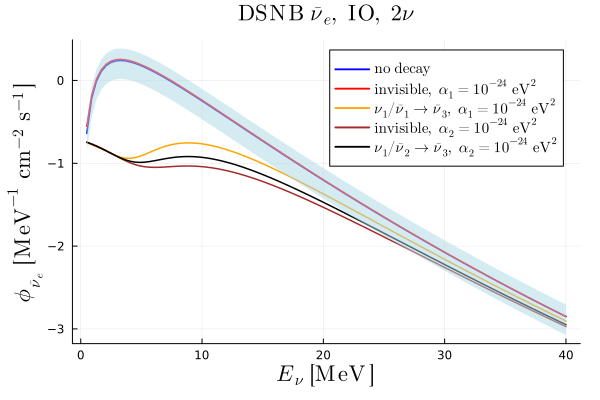

In [548]:
plot(
    es_dsnb_test, 
    [log10.(dsnb_nodecay_ebar_IO) log10.(DSNB_vdecay_νe_3ν_A_25) log10.(DSNB_vdecay_νe_3ν_B_25) log10.(DSNB_vdecay_νe_3ν_C_25) log10.(dsnb_vdecay_νe_3ν_25)],
    c=[:blue :red :orange :brown :black],
    lw=[1.5 1.5 1.5 1.5 1.5],
    ls=[:solid :solid :solid :solid :solid],
    alpha=[1 1 1 1 1],
    label=[L"\mathrm{no~decay}" L"\mathrm{invisible,~\alpha_1 = 10^{-24}~eV^2}" L"\nu_1/\bar{\nu}_1 \to \bar{\nu}_3,~\mathrm{\alpha_1=10^{-24}~eV^2}" L"\mathrm{invisible,~\alpha_2 = 10^{-24}~eV^2}" L"\nu_1/\bar{\nu}_2 \to \bar{\nu}_3,~\mathrm{\alpha_2=10^{-24}~eV^2}"],
    title=L"\mathrm{DSNB}~\bar{\nu}_e,\mathrm{~IO,~2\nu}",
    ylabel=L"\phi_{\bar{\nu}_e}~[\mathrm{MeV^{-1}~cm^{-2}~s^{-1}}]",
    xlabel=L"E_\nu~\mathrm{[MeV]}",
    xguidefontsize=15,
    yguidefontsize=15,
    titlefontsize=15,
    legendfontsize=10,
    margins=3Plots.mm
)
plot!(es_dsnb_test,
    log10.(dsnb_nodecay_ebar_IO_low),
    alpha=0,
    fillrange=log10.(dsnb_nodecay_ebar_IO_high),
    fillalpha=0.5,
    c=:lightblue,
    label=false
)

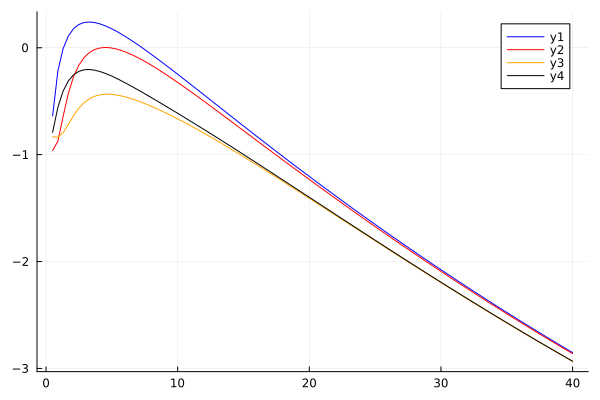

In [194]:
plot(
    es_dsnb_test,
    [log10.(dsnb_nodecay_IO) log10.(dsnb_vdecay_νe_3ν_26) log10.(dsnb_vdecay_νe_3ν_26_25) log10.(dsnb_vdecay_νe_2ν_25_IO_alt)],
    c=[:blue :red :orange :black]
)